In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve, accuracy_score, precision_score, recall_score, roc_auc_score
import folium
from folium.plugins import HeatMapWithTime
from IPython.display import display
from sklearn.linear_model import LogisticRegression


In [ ]:
# Read excel file
df = pd.read_excel('Crime_2024_with_Weather_Unemp_Monthly.xlsx')

df.head()

,date_reported,date_of_occurrence,time_of_occurrence,area_code,area_name,reporting_district_number,crime_part_category,crime_code_description,victim_age,victim_sex,...,case_status_description,location_string,latitude,longitude,daily_precipitation_mm,daily_avg_temperature_celsius,month,unemployment_rate_pct,victim_descent_code_new,victim_sex_new
0,4/25/24 0:00,2024-04-25,1600,21,Topanga,2146,1,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),0.0,NaN,...,Adult Other,21400 SHERMAN WY,34.2010,-118.5977,0.3,13.85,4,5.0,0.0,0.0
1,1/21/24 0:00,2024-01-21,1510,6,Hollywood,668,2,BATTERY - SIMPLE ASSAULT,22.0,F,...,Invest Cont,1300 N WESTERN AV,34.0944,-118.3125,9.4,13.75,1,5.6,1.0,1.0
2,8/29/24 0:00,2024-08-28,1500,11,Northeast,1123,1,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),0.0,NaN,...,Invest Cont,3600 BRUNSWICK AV,34.1187,-118.2604,0.0,23.25,8,6.7,NaN,NaN
3,3/22/24 0:00,2024-03-22,1815,21,Topanga,2145,2,BATTERY - SIMPLE ASSAULT,58.0,M,...,Adult Other,22000 GILMORE ST,34.1876,-118.6070,0.0,15.70,3,5.3,4.0,0.0
4,9/6/24 0:00,2024-09-05,1800,10,West Valley,1027,1,BURGLARY FROM VEHICLE,0.0,NaN,...,Invest Cont,6800 LOUISE AV,34.1939,-118.5098,0.0,34.00,9,6.0,0.0,0.0


# Data pre-processing

We begin by preparing the target variable and extracting key features for our binary classification model. The response variable `crime_part_category` is recoded so that misdemeanors are labeled as 0 and felonies as 1. To capture temporal patterns in crime, we derive an `is_weekend` indicator from the `date_of_occurrence`, assigning a value of 1 if the crime occurred on a Saturday or Sunday, and 0 otherwise. In addition, we extract the hour component from the four-digit `time_of_occurrence` field to reflect the time of day when the crime took place. These transformations allow us to incorporate both calendar-based and time-of-day information into our model.

In [24]:
# --- y variable ---
y = df['crime_part_category']  
y = y.replace({1: 0, 2: 1}) # 0=misdemeanor, 1=felony

# Whether it's a weekend is_weekend
df['dayofweek'] = df['date_of_occurrence'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

# Extract hour
def extract_hour(x):
    try:
        x_str = str(int(x)).zfill(4)
        return int(x_str[:2])
    except:
        return np.nan

df['hour'] = df['time_of_occurrence'].apply(extract_hour)

## One-hot coding

We perform one-hot encoding on three categorical variables: `area_name`, `victim_sex`, and `victim_descent_code`, using `pd.get_dummies` with `drop_first=False` to preserve all category levels. In addition to the encoded categorical features, we include a set of numerical predictors: `month`, `is_weekend`, `hour`, `victim_age`, `daily_precipitation_mm`, `daily_avg_temperature_celsius`, and `unemployment_rate_pct`. We then construct the final feature matrix `X` by combining the numerical columns with the newly generated one-hot encoded columns extracted from the transformed dataframe. This matrix serves as the input for our classification model.

In [25]:
# Select the columns that need to be One-Hot
onehot_cols = ['area_name', 'victim_sex', 'victim_descent_code']

# One-Hot coding directly with get_dummies
df_onehot = pd.get_dummies(df, columns=onehot_cols, drop_first=False)

# Numerical Characteristics
numerical_cols = [
    'month', 'is_weekend', 'hour',
    'victim_age',
    'daily_precipitation_mm', 'daily_avg_temperature_celsius', 'unemployment_rate_pct'
]

# Finding One-Hot Columns from df_onehot
onehot_feature_cols = [col for col in df_onehot.columns if col.startswith('area_name_') 
                                                        or col.startswith('victim_sex_') 
                                                        or col.startswith('victim_descent_code_')]

# Merge all feature columns
feature_cols = numerical_cols + onehot_feature_cols

# Final X-matrix

X = df_onehot[feature_cols]
X = X.drop(columns=['victim_descent_code_new', 'victim_sex_new'])


## Split train and test set

We split the data into training and test sets using a 70/30 split. To ensure that the class distribution (i.e., felony vs. misdemeanor) remains consistent across both sets, we apply stratified sampling based on the target variable `y`. A fixed `random_state` is used for reproducibility.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train = X_train.dropna(axis=1)

# Logistic regression

We train a logistic regression model using the same feature set to predict whether a crime is a felony. After fitting the model on the training data, we evaluate its performance on the test set using accuracy, ROC AUC, precision, and recall. These metrics allow us to assess both the overall classification quality and the model’s ability to correctly identify serious crimes (felonies). The probabilistic output from the model is also used to generate the ROC curve for visual comparison with tree-based models.

In [27]:
# Logistic regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Predict
y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:, 1]

# Evaluation
print("Logistic regression:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Precision:", precision_score(y_test, y_pred, pos_label=1))
print("Recall:", recall_score(y_test, y_pred, pos_label=1))

Logistic regression:
Accuracy: 0.740828804347826
ROC AUC: 0.8212366206889112
Precision: 0.5915543900895198
Recall: 0.547722705961152


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Random Forest & XGBoost

We train two classification models—Random Forest and XGBoost—to predict whether a given crime is a felony or a misdemeanor. Both models are trained using the same set of features and evaluated on the test set. For Random Forest, we use 100 trees with a fixed random seed. For XGBoost, we specify `logloss` as the evaluation metric to align with the binary classification objective.

To assess model performance, we report four standard classification metrics: **Accuracy**, **ROC AUC**, **Precision**, and **Recall**, focusing on the positive class (felony). These metrics help evaluate not only overall correctness but also the model’s ability to detect serious crimes.

In [28]:
# ----------------------------
# Random Forest
# ----------------------------
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# ----------------------------
# XGBoost
# ----------------------------
xgb_model = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# ----------------------------
# Evaluation
# ----------------------------
print("Random Forest:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))
print("Precision:", precision_score(y_test, y_pred_rf, pos_label=1))
print("Recall:", recall_score(y_test, y_pred_rf, pos_label=1))

print("\nXGBoost:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_proba_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb, pos_label=1))
print("Recall:", recall_score(y_test, y_pred_xgb, pos_label=1))

Random Forest:
Accuracy: 0.7999059364548495
ROC AUC: 0.8923927752814054
Precision: 0.6770196596728895
Recall: 0.6862022772940388

XGBoost:
Accuracy: 0.8171247909698997
ROC AUC: 0.9100901234908048
Precision: 0.6939367793552436
Recall: 0.7407066309444073


## ROC Curve

The ROC curve compares the classification performance of three models: Random Forest, XGBoost, and Logistic Regression. Both Random Forest and XGBoost achieve an AUC of 0.85, indicating strong ability to distinguish between felonies and misdemeanors. Logistic Regression performs slightly lower, with an AUC of 0.82. Overall, tree-based models show a slight edge in predictive power, especially at lower false positive rates. The curves confirm that all models perform significantly better than random guessing.

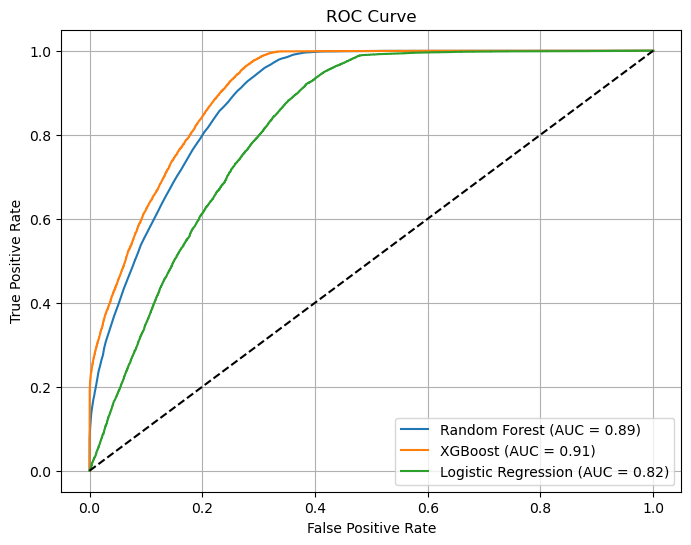

In [29]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf, pos_label=1)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb, pos_label=1)
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba, pos_label=1)  # y_proba from logistic

plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = %.2f)' % auc(fpr_rf, tpr_rf))
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (AUC = %.2f)' % auc(fpr_xgb, tpr_xgb))
plt.plot(fpr_log, tpr_log, label='Logistic Regression (AUC = %.2f)' % auc(fpr_log, tpr_log))
plt.plot([0,1], [0,1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()


## Precision-Recall curve

The precision-recall curve compares the performance of Random Forest, XGBoost, and Logistic Regression in identifying felonies. Both tree-based models maintain high precision at low recall levels, indicating strong performance in identifying the most confident felony predictions. In contrast, Logistic Regression starts with a sharp drop in precision at very low recall—an expected behavior when very few positive predictions are made early and one misclassification leads to zero precision. As recall increases, Logistic Regression shows a more stable precision-recall trade-off, while Random Forest and XGBoost gradually decline. Overall, the tree-based models outperform Logistic Regression across most recall levels, particularly in high-precision regions.

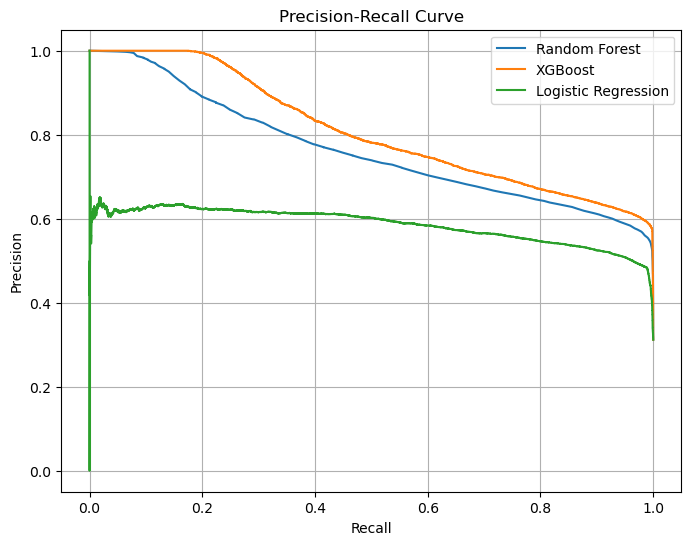

In [30]:
prec_rf, rec_rf, _ = precision_recall_curve(y_test, y_proba_rf, pos_label=1)
prec_xgb, rec_xgb, _ = precision_recall_curve(y_test, y_proba_xgb, pos_label=1)
prec_log, rec_log, _ = precision_recall_curve(y_test, y_proba, pos_label=1)  # Logistic regression

plt.figure(figsize=(8,6))
plt.plot(rec_rf, prec_rf, label='Random Forest')
plt.plot(rec_xgb, prec_xgb, label='XGBoost')
plt.plot(rec_log, prec_log, label='Logistic Regression')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

## Feature importance

The feature importance plot shows the top 15 predictors used by the Random Forest model to distinguish between felonies and misdemeanors. `victim_age` and `daily_avg_temperature_celsius` are the two most influential features, suggesting that both demographic and environmental factors significantly impact the likelihood of a crime being a felony. Time-related variables like `hour` and `month` also contribute meaningfully, indicating temporal patterns in serious crimes. Several victim-related characteristics—including sex and descent code—appear among the top features, highlighting the relevance of demographic factors. While socioeconomic indicators such as `unemployment_rate_pct` and `is_weekend` show lower importance, they still provide additional context in the model’s decision process.

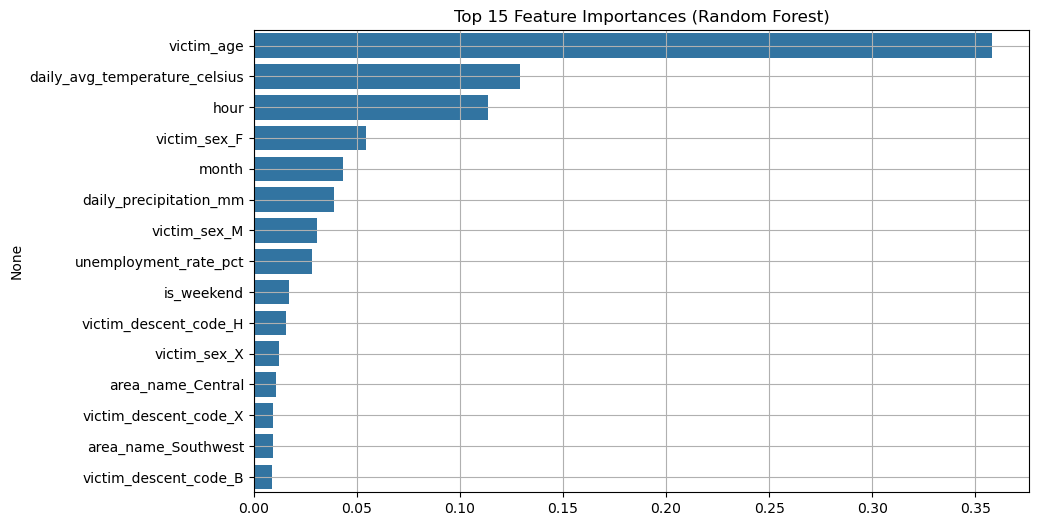

In [31]:
importances = rf_model.feature_importances_
feat_names = X.columns

feat_importances = pd.Series(importances, index=feat_names)
feat_importances = feat_importances.sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_importances.values[:15], y=feat_importances.index[:15])
plt.title('Top 15 Feature Importances (Random Forest)')
plt.grid()
plt.show()

# Area crime distribution

We visualize the spatial and temporal distribution of crimes across Los Angeles using a time-based heatmap. First, we filter the dataset to include only records with valid latitude and longitude values. For each month, we extract up to 5,000 random crime locations to avoid overcrowding the map. These monthly subsets are compiled into a list of coordinates required by `folium`'s `HeatMapWithTime`. We then generate an interactive map centered on Los Angeles, which displays a dynamic heatmap that animates month by month throughout 2024. This visualization highlights how crime density varies spatially and evolves over time.

In [32]:

# Only keep data with latitude and longitude
df = df.dropna(subset=['latitude', 'longitude'])

# Organize data into the format required by HeatMap
heat_data_by_month = []
months = sorted(df['month'].unique())

for month in months:
    monthly_data = df[df['month'] == month]
    
    # Sample, avoid too many points
    if monthly_data.shape[0] > 5000:
        monthly_data = monthly_data.sample(5000, random_state=42)
    
    month_coords = monthly_data[['latitude', 'longitude']].values.tolist()
    heat_data_by_month.append(month_coords)

# Create map  
la_map = folium.Map(location=[34.0522, -118.2437], zoom_start=11)

# Add time heatmap
HeatMapWithTime(
    heat_data_by_month,
    index=[f'2024-{m:02d}' for m in months],
    radius=8,
    auto_play=True,
    max_opacity=0.8
).add_to(la_map)

# Display map
display(la_map)


This static heatmap shows the spatial concentration of crimes across the Los Angeles metropolitan area. Each point represents a crime location, with warmer colors (yellow to red) indicating higher density. The map reveals several hotspots of criminal activity, particularly in central and south Los Angeles, as well as areas around Santa Monica and Long Beach. The geographic clustering highlights regions with persistently high crime volume and can guide targeted interventions or further localized analysis.